[2025-04-08 10:55:00] Found first high candle (Index 1). High: 1174.62, MA High: 1173.45. Storing High Level: 1174.62

 *** BUY TRIGGER ***
[2025-04-08 11:00:00] Price (1177.07) crossed above First High Level (1174.62).
Buy Price: 1177.07

 *** SELL TRIGGER ***
[2025-04-08 12:25:00] Price (1182.09) touched/crossed below MA Low (1184.77).
Sell Price: 1182.09
Profit/Loss: 5.02
[2025-04-08 12:25:00] Resetting state to LOOKING_FOR_HIGH for next trade.

[2025-04-08 13:30:00] Found first high candle (Index 32). High: 1184.15, MA High: 1181.32. Storing High Level: 1184.15

 *** BUY TRIGGER ***
[2025-04-08 14:15:00] Price (1184.59) crossed above First High Level (1184.15).
Buy Price: 1184.59

 *** SELL TRIGGER ***
[2025-04-08 19:00:00] Price (1220.89) touched/crossed below MA Low (1222.51).
Sell Price: 1220.89
Profit/Loss: 36.30
[2025-04-08 19:00:00] Resetting state to LOOKING_FOR_HIGH for next trade.



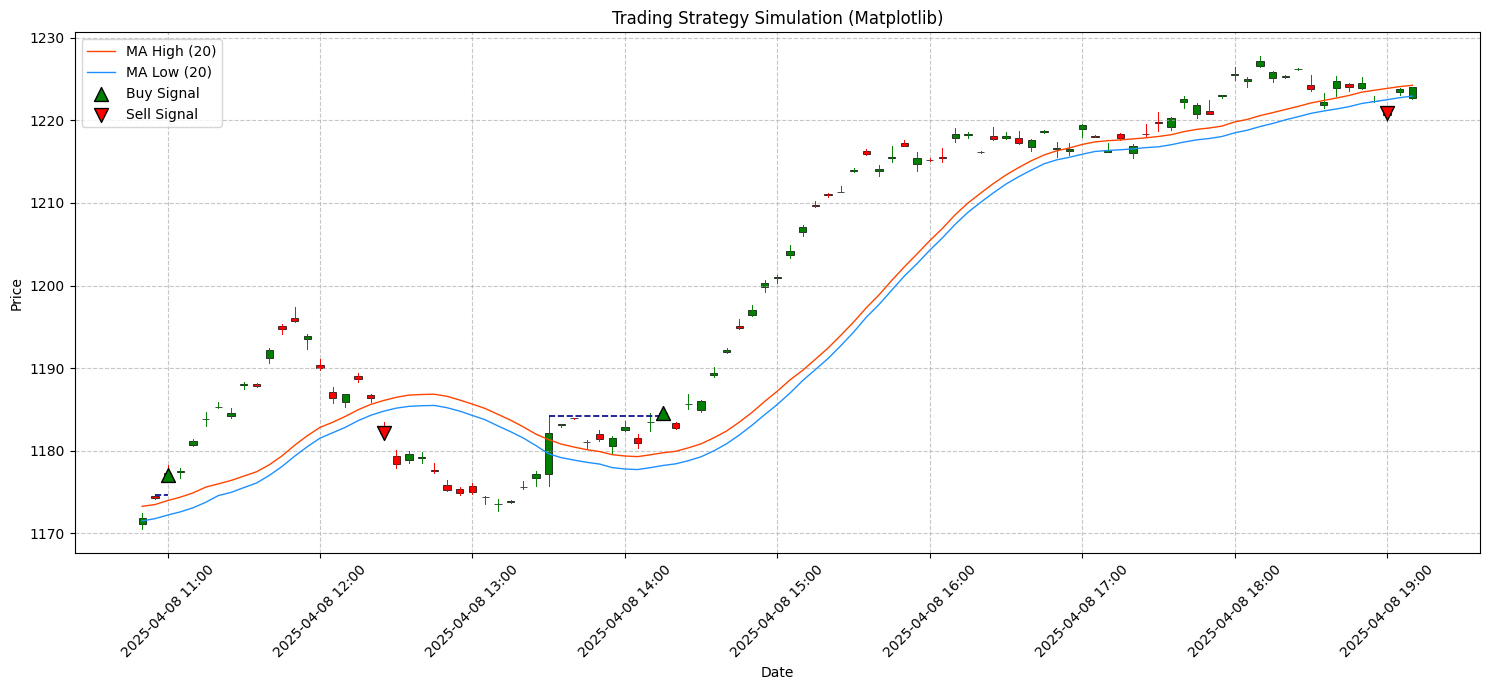


--- Trade Summary (Display) ---
              Buy Time            Sell Time Buying Price Selling Price  \
0  2025-04-08 11:00:00  2025-04-08 12:25:00      1177.07       1182.09   
1  2025-04-08 14:15:00  2025-04-08 19:00:00      1184.59       1220.89   

  Profit/Loss  
0        5.02  
1       36.30  

Trade summary exported to trade_summary.csv


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle # For candlestick bodies

# --- 1. Generate More Comprehensive Dummy Data ---
# Create a more extensive time range for better demonstration
dates = pd.to_datetime(pd.date_range(start='2025-04-08 09:15:00', periods=120, freq='5min')) # More data points for multiple trades
np.random.seed(42) # for reproducibility

# Simulate price movements that might trigger the strategy multiple times
price = 1170
opens = []
highs = []
lows = []
closes = []

def generate_price_segment(start_price, num_periods, trend_factor, volatility_high, volatility_low):
    """Helper function to generate a segment of price data."""
    segment_opens, segment_highs, segment_lows, segment_closes = [], [], [], []
    current_p = start_price
    for _ in range(num_periods):
        change = np.random.uniform(-volatility_low, volatility_high) + trend_factor
        o = current_p + change
        h = o + np.random.uniform(0, volatility_high/2)
        l = o - np.random.uniform(0, volatility_low/2)
        # Ensure low is not higher than open/high and high is not lower than open/low
        l = min(l, o, h)
        h = max(h, o, l)
        c = np.random.uniform(l, h)

        segment_opens.append(o)
        segment_highs.append(h)
        segment_lows.append(l)
        segment_closes.append(c)
        current_p = c
    return segment_opens, segment_highs, segment_lows, segment_closes, current_p

# Segment 1: Initial stable, then first high candle
s1_o, s1_h, s1_l, s1_c, price = generate_price_segment(price, 5, 0, 2, 2)
opens.extend(s1_o); highs.extend(s1_h); lows.extend(s1_l); closes.extend(s1_c)
# "first high candle"
opens.append(price); highs.append(price + 8); lows.append(price - 1); closes.append(price + 6); price = closes[-1]

# Segment 2: Drop below low MA
s2_o, s2_h, s2_l, s2_c, price = generate_price_segment(price, 10, -0.5, 4, 3) # Trend down
opens.extend(s2_o); highs.extend(s2_h); lows.extend(s2_l); closes.extend(s2_c)

# Segment 3: Upswing and buy trigger
s3_o, s3_h, s3_l, s3_c, price = generate_price_segment(price, 15, 0.8, 3, 2) # Trend up
opens.extend(s3_o); highs.extend(s3_h); lows.extend(s3_l); closes.extend(s3_c)

# Segment 4: Reaching sell trigger
s4_o, s4_h, s4_l, s4_c, price = generate_price_segment(price, 10, -0.6, 3, 3) # Trend down to sell
opens.extend(s4_o); highs.extend(s4_h); lows.extend(s4_l); closes.extend(s4_c)

# Segment 5: Setup for a second trade - stable then new high
s5_o, s5_h, s5_l, s5_c, price = generate_price_segment(price, 10, 0.1, 2, 2)
opens.extend(s5_o); highs.extend(s5_h); lows.extend(s5_l); closes.extend(s5_c)
opens.append(price); highs.append(price + 7); lows.append(price - 1.5); closes.append(price + 5); price = closes[-1] # Second "first high candle"

# Segment 6: Drop below low MA again
s6_o, s6_h, s6_l, s6_c, price = generate_price_segment(price, 10, -0.4, 3.5, 2.5)
opens.extend(s6_o); highs.extend(s6_h); lows.extend(s6_l); closes.extend(s6_c)

# Segment 7: Upswing and buy trigger again
s7_o, s7_h, s7_l, s7_c, price = generate_price_segment(price, 15, 0.7, 2.5, 1.5)
opens.extend(s7_o); highs.extend(s7_h); lows.extend(s7_l); closes.extend(s7_c)

# Segment 8: Fill remaining data, potentially leading to another sell
remaining_periods = len(dates) - len(closes)
if remaining_periods > 0:
    s8_o, s8_h, s8_l, s8_c, price = generate_price_segment(price, remaining_periods, -0.3, 3, 2)
    opens.extend(s8_o); highs.extend(s8_h); lows.extend(s8_l); closes.extend(s8_c)


# Create DataFrame
df = pd.DataFrame({
    'Date': dates[:len(opens)], # Ensure dates match the length of generated data
    'Open': opens,
    'High': highs,
    'Low': lows,
    'Close': closes
})

# Calculate Moving Averages
window = 20
df['MA_High'] = df['High'].rolling(window=window).mean()
df['MA_Low'] = df['Low'].rolling(window=window).mean()

# Drop initial NaN values from rolling mean calculation
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

# --- 2. Implement Trading Strategy Logic (with continuous trading) ---
state = "LOOKING_FOR_HIGH"
first_high_level = None
first_high_candle_index = None
min_low_below_ma = float('inf') # This will be tracked but not explicitly used for buy/sell decisions as per current logic
buy_price = None
sell_price = None
buy_time = None
sell_time = None
buy_index = None # For plotting
sell_index = None # For plotting

trade_log = [] # Stores dictionaries of trade details

# Store markers for plotting
buy_markers_x = []
buy_markers_y = []
sell_markers_x = []
sell_markers_y = []
first_high_lines = [] # Store (y_value, x_start_index, x_end_index) for plotting

current_first_high_line_y = None
current_first_high_line_start_idx = None


for i, row in df.iterrows():
    current_time = row['Date']
    current_high = row['High']
    current_low = row['Low']
    current_close = row['Close']
    current_ma_high = row['MA_High']
    current_ma_low = row['MA_Low']

    if state == "LOOKING_FOR_HIGH":
        if current_high > current_ma_high:
            first_high_level = current_high
            first_high_candle_index = i
            print(f"[{current_time}] Found first high candle (Index {i}). High: {current_high:.2f}, MA High: {current_ma_high:.2f}. Storing High Level: {first_high_level:.2f}")
            state = "LOOKING_FOR_LOW"
            min_low_below_ma = float('inf') # Reset min low tracking for this cycle
            
            # For plotting the horizontal line
            current_first_high_line_y = first_high_level
            current_first_high_line_start_idx = i


    elif state == "LOOKING_FOR_LOW":
        if current_low < current_ma_low:
            min_low_below_ma = min(min_low_below_ma, current_low)
            # print(f"[{current_time}] Low ({current_low:.2f}) is below MA Low ({current_ma_low:.2f}). Min Low tracked: {min_low_below_ma:.2f}")

        if first_high_level is not None and current_close > first_high_level:
            buy_price = current_close # Buy at the close of the breakout candle
            buy_time = current_time
            buy_index = i
            print(f"\n *** BUY TRIGGER ***")
            print(f"[{buy_time}] Price ({current_close:.2f}) crossed above First High Level ({first_high_level:.2f}).")
            print(f"Buy Price: {buy_price:.2f}")
            state = "HOLDING"
            buy_markers_x.append(current_time)
            buy_markers_y.append(buy_price)

            # Store the first high line segment for plotting
            if current_first_high_line_y is not None and current_first_high_line_start_idx is not None:
                 first_high_lines.append({
                     'y': current_first_high_line_y,
                     'xmin_date': df.loc[current_first_high_line_start_idx, 'Date'],
                     'xmax_date': current_time # Line extends until buy
                 })
            current_first_high_line_y = None # Reset for next potential line
            current_first_high_line_start_idx = None


    elif state == "HOLDING":
        if current_close <= current_ma_low:
            sell_price = current_close # Sell at the close of the breakdown candle
            sell_time = current_time
            sell_index = i
            profit = sell_price - buy_price
            print(f"\n *** SELL TRIGGER ***")
            print(f"[{sell_time}] Price ({current_close:.2f}) touched/crossed below MA Low ({current_ma_low:.2f}).")
            print(f"Sell Price: {sell_price:.2f}")
            print(f"Profit/Loss: {profit:.2f}")

            trade_log.append({
                "Buy Time": buy_time,
                "Sell Time": sell_time,
                "Buying Price": buy_price,
                "Selling Price": sell_price,
                "Profit/Loss": profit
            })
            sell_markers_x.append(current_time)
            sell_markers_y.append(sell_price)

            # Reset for next trade
            print(f"[{current_time}] Resetting state to LOOKING_FOR_HIGH for next trade.\n")
            state = "LOOKING_FOR_HIGH"
            first_high_level = None
            first_high_candle_index = None
            min_low_below_ma = float('inf')
            buy_price = None
            # buy_time, sell_time, buy_index, sell_index are implicitly reset or overwritten

# --- 3. Create Visualization with Matplotlib ---
fig, ax = plt.subplots(figsize=(15, 7))

# Plotting Candlesticks
candlestick_width = 0.002 # Adjust based on your date frequency, 5 min = 1/(24*12) approx

for idx, row_data in df.iterrows():
    date = mdates.date2num(row_data['Date'])
    open_price = row_data['Open']
    close_price = row_data['Close']
    high_price = row_data['High']
    low_price = row_data['Low']

    color = 'green' if close_price >= open_price else 'red'
    # Body
    rect = Rectangle((date - candlestick_width/2, min(open_price, close_price)), candlestick_width, abs(close_price - open_price), facecolor=color, edgecolor='black', lw=0.5)
    ax.add_patch(rect)
    # Wick/Shadow
    ax.plot([date, date], [low_price, high_price], color=color, linewidth=0.7)


# Plot Moving Averages
ax.plot(df['Date'], df['MA_High'], color='orangered', linestyle='-', linewidth=1, label='MA High (20)')
ax.plot(df['Date'], df['MA_Low'], color='dodgerblue', linestyle='-', linewidth=1, label='MA Low (20)')

# Plot First High Level Lines
for line_info in first_high_lines:
    ax.hlines(y=line_info['y'], xmin=line_info['xmin_date'], xmax=line_info['xmax_date'],
              color='darkblue', linestyle='--', linewidth=1.2,
              label='First High Level (Active)' if line_info == first_high_lines[-1] and state != "LOOKING_FOR_HIGH" else '_nolegend_')


# Plot Buy Markers
if buy_markers_x:
    ax.scatter(buy_markers_x, buy_markers_y, color='green', marker='^', s=100, edgecolor='black', label='Buy Signal', zorder=5)

# Plot Sell Markers
if sell_markers_x:
    ax.scatter(sell_markers_x, sell_markers_y, color='red', marker='v', s=100, edgecolor='black', label='Sell Signal', zorder=5)

# Formatting the plot
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.xticks(rotation=45)
plt.title('Trading Strategy Simulation (Matplotlib)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

# --- 4. Create Summary Table and Export to CSV ---
summary_df = pd.DataFrame(trade_log)

if not summary_df.empty:
    # Ensure correct data types before formatting for display, keep original for CSV
    summary_df_display = summary_df.copy()
    summary_df_display['Buy Time'] = summary_df_display['Buy Time'].dt.strftime('%Y-%m-%d %H:%M:%S')
    summary_df_display['Sell Time'] = summary_df_display['Sell Time'].dt.strftime('%Y-%m-%d %H:%M:%S')
    summary_df_display['Buying Price'] = summary_df_display['Buying Price'].map('{:.2f}'.format)
    summary_df_display['Selling Price'] = summary_df_display['Selling Price'].map('{:.2f}'.format)
    summary_df_display['Profit/Loss'] = summary_df_display['Profit/Loss'].map('{:.2f}'.format)
    
    print("\n--- Trade Summary (Display) ---")
    print(summary_df_display)

    # Export to CSV
    csv_filename = 'trade_summary.csv'
    summary_df.to_csv(csv_filename, index=False, date_format='%Y-%m-%d %H:%M:%S')
    print(f"\nTrade summary exported to {csv_filename}")

else:
    print("\nNo complete buy/sell cycles triggered with the current data and logic.")

